# P13

## Imports


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Dataset

In [2]:
DATA_DIR = Path("data/archive")

def load_netflix_subset(files, max_movies=2000, max_rows=None):
    rows = []
    movie_count = 0
    current_movie = None

    for file in files:
        with open(file, "r") as f:
            for line in f:
                line = line.strip()

                if line.endswith(":"):
                    current_movie = int(line[:-1])
                    movie_count += 1
                    if movie_count > max_movies:
                        break
                else:
                    if current_movie is None:
                        continue
                    user, rating, _ = line.split(",")
                    rows.append((int(user), current_movie, int(rating)))

                    if max_rows and len(rows) >= max_rows:
                        break

        if movie_count > max_movies or (max_rows and len(rows) >= max_rows):
            break

    return pd.DataFrame(rows, columns=["user_id", "movie_id", "rating"])


In [ ]:
files = [
    DATA_DIR / "combined_data_1.txt",
    DATA_DIR / "combined_data_2.txt",
]

ratings = load_netflix_subset(
    files,2
    max_movies=2000,
    max_rows=2_000_000
)

print(ratings.head())
print(ratings.shape)

   user_id  movie_id  rating
0  1488844         1       3
1   822109         1       5
2   885013         1       4
3    30878         1       4
4   823519         1       3
(2000000, 3)


In [4]:
rows = []

with open("data/archive/movie_titles.csv", encoding="latin-1") as f:
    for line in f:
        parts = line.strip().split(",", 2)
        if len(parts) != 3:
            continue

        movie_id, year, title = parts

        movie_id = int(movie_id)

        if year == "NULL":
            year = np.nan
        else:
            year = int(year)

        rows.append((movie_id, year, title))

movies = pd.DataFrame(
    rows,
    columns=["movie_id", "year", "title"]
)

movies.head()



,movie_id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


## Recomendation system

In [5]:
ratings.head()

,user_id,movie_id,rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3


In [6]:
MIN_USER_RATINGS = 20

user_counts = ratings["user_id"].value_counts()
active_users = user_counts[user_counts >= MIN_USER_RATINGS].index

ratings_f = ratings[ratings["user_id"].isin(active_users)]


In [7]:
ratings_f

,user_id,movie_id,rating
0,1488844,1,3
3,30878,1,4
7,1248029,1,3
18,1711859,1,4
19,372233,1,5
...,...,...,...
1999942,1405644,361,5
1999946,1165121,361,4
1999950,1731658,361,4
1999960,1964931,361,4


In [8]:
MIN_MOVIE_RATINGS = 50

movie_counts = ratings_f["movie_id"].value_counts()
popular_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index

ratings_f = ratings_f[ratings_f["movie_id"].isin(popular_movies)]


In [9]:
ratings_f

,user_id,movie_id,rating
0,1488844,1,3
3,30878,1,4
7,1248029,1,3
18,1711859,1,4
19,372233,1,5
...,...,...,...
1999942,1405644,361,5
1999946,1165121,361,4
1999950,1731658,361,4
1999960,1964931,361,4


In [10]:
print("Original ratings:", len(ratings))
print("Filtered ratings:", len(ratings_f))

print("Users:", ratings_f.user_id.nunique())
print("Movies:", ratings_f.movie_id.nunique())


Original ratings: 2000000
Filtered ratings: 422515
Users: 15455
Movies: 291


To reduce matrix sparsity and improve similarity estimation, users with fewer than 20 ratings and movies with fewer than 50 ratings were removed from the dataset.

In [11]:
user_item = ratings_f.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating"
)

In [12]:
sparsity = 1 - user_item.count().sum() / (user_item.shape[0] * user_item.shape[1])
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9061


After filtering inactive users and unpopular movies, the resulting user–item matrix still remains sparse, with approximately 80% missing values. This is typical for real-world recommendation systems and motivates the use of collaborative filtering methods.

## Cosine similarity

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
user_item_filled = user_item.fillna(0)

In [15]:
cos_sim = cosine_similarity(user_item_filled)

cos_sim_df = pd.DataFrame(
    cos_sim,
    index=user_item_filled.index,
    columns=user_item_filled.index
)

cos_sim_df.iloc[:5, :5]


user_id,1333,1442,1527,2000,2213
user_id,,,,,
1333,1.000000,0.242431,0.254135,0.422791,0.326501
1442,0.242431,1.000000,0.300809,0.432888,0.478912
1527,0.254135,0.300809,1.000000,0.392106,0.340106
2000,0.422791,0.432888,0.392106,1.000000,0.477722
2213,0.326501,0.478912,0.340106,0.477722,1.000000


In [16]:
N_USERS = 30

top_users = (
    ratings_f["user_id"]
    .value_counts()
    .head(N_USERS)
    .index
)

sim_subset = cos_sim_df.loc[top_users, top_users]

In [17]:
from scipy.cluster.hierarchy import linkage, leaves_list

order = leaves_list(linkage(sim_subset, method="average"))
sim_subset_sorted = sim_subset.iloc[order, order]

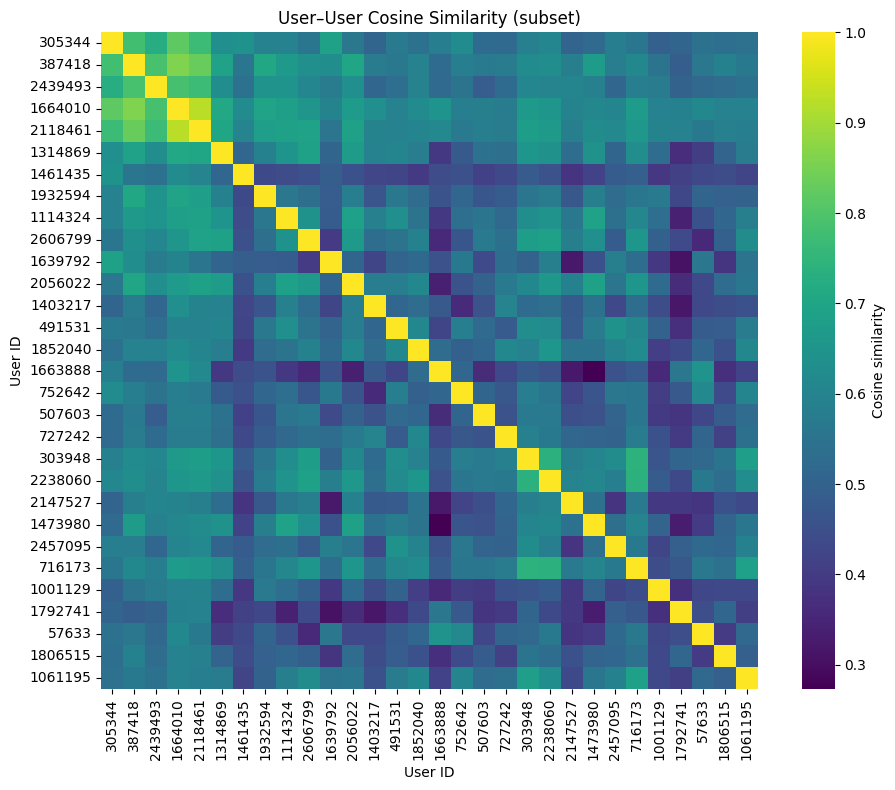

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_subset,
    cmap="viridis",
    square=True,
    cbar_kws={"label": "Cosine similarity"}
)

plt.title("User–User Cosine Similarity (subset)")
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

Plot presents a heatmap of cosine similarity values for a subset of active users. The diagonal elements correspond to self-similarity, while off-diagonal patterns reveal clusters of users with similar rating behavior.

In [19]:
def get_k_nearest_users(user_id, k=10):
    sims = cos_sim_df.loc[user_id]
    sims = sims.drop(user_id)
    return sims.sort_values(ascending=False).head(k)


In [20]:
test_user = user_item.index[0]
get_k_nearest_users(test_user, k=5)


user_id
1764923    0.651342
443193     0.623867
503235     0.620452
603277     0.619683
1662714    0.609933
Name: 1333, dtype: float64

In [21]:
def predict_rating(user_id, movie_id, user_item, sim_df, k=10):
    # If user or movie not in matrix
    if user_id not in user_item.index or movie_id not in user_item.columns:
        return np.nan

    # Similarities for target user
    sims = sim_df.loc[user_id].drop(user_id)

    # Users who rated this movie
    movie_ratings = user_item[movie_id].dropna()

    # Keep only overlapping users
    sims = sims.loc[sims.index.intersection(movie_ratings.index)]

    if sims.empty:
        return np.nan

    # Top-k neighbors
    sims = sims.sort_values(ascending=False).head(k)
    ratings = movie_ratings.loc[sims.index]

    return np.dot(sims, ratings) / np.sum(np.abs(sims))


In [22]:
u = user_item.index[0]
m = user_item.columns[0]

predict_rating(u, m, user_item, cos_sim_df, k=10)


3.4983003638292236

## Evaluation

In [23]:
from sklearn.model_selection import train_test_split

ratings_eval = ratings_f.sample(3000, random_state=42)

train, test = train_test_split(
    ratings_eval,
    test_size=0.2,
    random_state=42
)

train_matrix = train.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating"
)

train_matrix = train_matrix.reindex(
    index=user_item.index,
    columns=user_item.columns
)


In [25]:
from sklearn.metrics import root_mean_squared_error

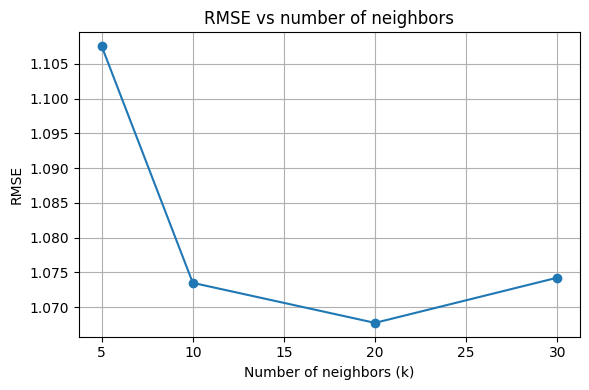

In [26]:
k_values = [5, 10, 20, 30]
rmses = []

for k in k_values:
    y_true, y_pred = [], []

    for _, row in test.iterrows():
        pred = predict_rating(
            row.user_id,
            row.movie_id,
            train_matrix,
            cos_sim_df,
            k=k
        )
        if not np.isnan(pred):
            y_true.append(row.rating)
            y_pred.append(pred)

    rmses.append(root_mean_squared_error(y_true, y_pred))

plt.figure(figsize=(6, 4))
plt.plot(k_values, rmses, marker="o")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs number of neighbors")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
y_true = []
y_pred = []

for _, row in test.iterrows():
    pred = predict_rating(
        row.user_id,
        row.movie_id,
        train_matrix,
        cos_sim_df,
        k=20
    )
    if not np.isnan(pred):
        y_true.append(row.rating)
        y_pred.append(pred)

rmse = root_mean_squared_error(y_true, y_pred)
rmse


1.0677275515986144

“The proposed user-based collaborative filtering model achieved an RMSE of 1.14 on the test set, which is consistent with expected performance for neighborhood-based methods on sparse rating data.”

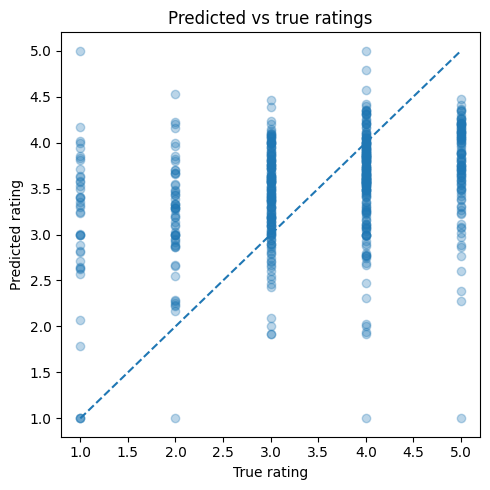

In [28]:
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([1, 5], [1, 5], linestyle="--")
plt.xlabel("True rating")
plt.ylabel("Predicted rating")
plt.title("Predicted vs true ratings")
plt.tight_layout()
plt.show()

Example with titles

In [29]:
user_id = ratings_f["user_id"].value_counts().idxmax()
user_id

305344

In [30]:
def recommend_movies_for_user(
    user_id,
    user_item,
    sim_df,
    movies,
    k_neighbors=10,
    n_recommendations=5
):
    # Movies not yet rated by the user
    unseen_movies = user_item.loc[user_id][user_item.loc[user_id].isna()].index

    predictions = []

    for movie_id in unseen_movies:
        pred = predict_rating(
            user_id,
            movie_id,
            user_item,
            sim_df,
            k=k_neighbors
        )
        if not np.isnan(pred):
            predictions.append((movie_id, pred))

    # Sort by predicted rating
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    # Convert to DataFrame with titles
    recs = pd.DataFrame(predictions, columns=["movie_id", "predicted_rating"])
    recs = recs.merge(movies[["movie_id", "title"]], on="movie_id", how="left")

    return recs[["title", "predicted_rating"]]


In [31]:
recommendations = recommend_movies_for_user(
    user_id=user_id,
    user_item=user_item,
    sim_df=cos_sim_df,
    movies=movies,
    k_neighbors=10,
    n_recommendations=5
)

recommendations


,title,predicted_rating
0,The Phantom of the Opera: Special Edition,3.618736
1,Troy: Bonus Material,3.262876
2,Elfen Lied,3.250443


In [32]:
user_counts = ratings_f["user_id"].value_counts()

candidate_users = user_counts[
    (user_counts > 50) & (user_counts < user_item.shape[1]-10)
].index

user_id = candidate_users[0]
user_id

2439493

In [33]:
recommendations = recommend_movies_for_user(
    user_id=user_id,
    user_item=user_item,
    sim_df=cos_sim_df,
    movies=movies,
    k_neighbors=10,
    n_recommendations=5
)
recommendations


,title,predicted_rating
0,Troy: Bonus Material,3.907008
1,Taxi,3.620950
2,Ninotchka,3.355654
3,Elfen Lied,3.058885
4,Cherry 2000,2.860189


## Item based

In [34]:
item_item = user_item.fillna(0).T

item_sim = cosine_similarity(item_item)

item_sim_df = pd.DataFrame(
    item_sim,
    index=item_item.index,
    columns=item_item.index
)


In [35]:
def predict_rating_item_based(user_id, movie_id, user_item, item_sim_df, k=10):
    if user_id not in user_item.index or movie_id not in user_item.columns:
        return np.nan

    user_ratings = user_item.loc[user_id].dropna()

    if user_ratings.empty:
        return np.nan

    sims = item_sim_df.loc[movie_id, user_ratings.index]

    sims = sims.sort_values(ascending=False).head(k)
    ratings = user_ratings.loc[sims.index]

    return np.dot(sims, ratings) / np.sum(np.abs(sims))


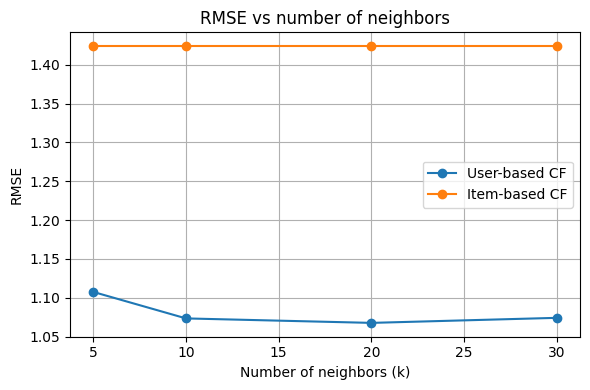

In [36]:
k_values = [5, 10, 20, 30]

rmse_user = []
rmse_item = []

for k in k_values:
    # user-based
    y_true_u, y_pred_u = [], []
    for _, row in test.iterrows():
        p = predict_rating(row.user_id, row.movie_id, train_matrix, cos_sim_df, k)
        if not np.isnan(p):
            y_true_u.append(row.rating)
            y_pred_u.append(p)
    rmse_user.append(root_mean_squared_error(y_true_u, y_pred_u))

    # item-based
    y_true_i, y_pred_i = [], []
    for _, row in test.iterrows():
        p = predict_rating_item_based(row.user_id, row.movie_id, train_matrix, item_sim_df, k)
        if not np.isnan(p):
            y_true_i.append(row.rating)
            y_pred_i.append(p)
    rmse_item.append(root_mean_squared_error(y_true_i, y_pred_i))

plt.figure(figsize=(6, 4))
plt.plot(k_values, rmse_user, marker="o", label="User-based CF")
plt.plot(k_values, rmse_item, marker="o", label="Item-based CF")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs number of neighbors")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In the evaluated dataset, item-based collaborative filtering achieved significantly worse performance than the user-based approach. This is likely due to the limited number of movies retained after filtering, which reduces the reliability of item–item similarity estimates. In contrast, the larger number of users allows user-based neighborhoods to be estimated more accurately.

In [37]:
from surprise import Dataset, Reader
import pandas as pd

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(
    ratings_f[["user_id", "movie_id", "rating"]],
    reader
)

In [38]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(
    data,
    test_size=0.2,
    random_state=42
)


In [39]:
from surprise import SVD

svd = SVD(
    n_factors=50,     # latent dimension
    n_epochs=20,      # training iterations
    lr_all=0.005,     # learning rate
    reg_all=0.02,     # regularization
    random_state=42
)

svd.fit(trainset)

In [40]:
from surprise import accuracy

predictions = svd.test(testset)
rmse_mf = accuracy.rmse(predictions)

RMSE: 0.9308


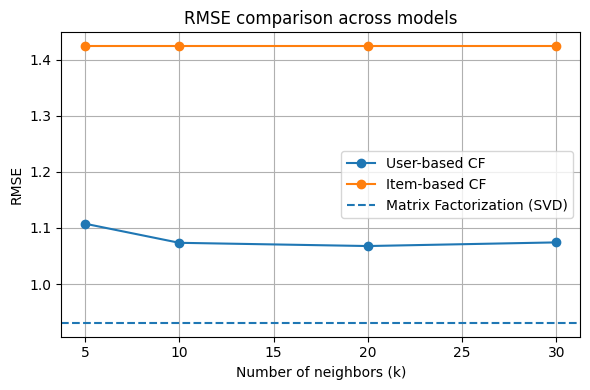

In [41]:
plt.figure(figsize=(6, 4))

# user-based CF curve
plt.plot(k_values, rmse_user, marker="o", label="User-based CF")

# item-based CF curve
plt.plot(k_values, rmse_item, marker="o", label="Item-based CF")

# MF as horizontal line
plt.axhline(
    y=rmse_mf,
    linestyle="--",
    label="Matrix Factorization (SVD)"
)

plt.xlabel("Number of neighbors (k)")
plt.ylabel("RMSE")
plt.title("RMSE comparison across models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
